In [14]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
from utils.datapoint import DataPoint
from utils.tools import get_RMSE, calculate_jacobian, cartesian_to_polar, time_difference
mpl.rcParams['figure.figsize'] = [10, 7]
mpl.rcParams['figure.dpi'] = 72
import matplotlib.pyplot as plt

---
## State Dynamics for a Constant Turn Rate and Velocity Vehicle Model (CTRV)
The below equation represent how the vehicle states evolve between time steps in a constant turn rate ($\dot{\psi}$) and velocity ($v_x, v_y$) vehicle model.

\begin{align}
    p_x' &= p_x + v_x * dt \\
    p_y' &= p_y + v_y * dt \\
    v_x' &= v_x \\
    v_y' &= v_y \\
    \psi' &= \psi + \dot{\psi} * dt \\
    \dot{\psi}' &= \dot{\psi}
\end{align}

$$ \begin{pmatrix} p_x' \\ p_y' \\ v_x' \\ v_y' \\ \psi' \\ \dot{\psi}' \end{pmatrix} = \begin{bmatrix} 1 & 0 & dt & 0 & 0 & 0\\ 0 & 1 & 0 & dt & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & dt \\ 0 & 0 & 0 & 0 & 0 & 1\end{bmatrix} \begin{pmatrix} p_x \\ p_y \\ v_x \\ v_y \\ \psi \\ \dot{\psi} \end{pmatrix} $$

---

**State transition function:**

$$x' = f(x) + \nu = F x + B u + \nu $$

If the motion control input $u =0$, then the state transition function simplifies to:

$$ x' = F x + \nu $$

>where, <br />
$\nu \sim N(0, Q)$ is the process noise which is assumed to be a Gaussian with zero mean and covariance matrix Q.

**Measurement function:**
$$ z = h(x') + \omega = Hx' + \omega $$

>where, <br />
$z$ is the measurement update, <br />
$H$ is the transformation matrix, <br />
$\omega \sim N(0, R)$ is the measurement noise which is assumed to be a Gaussian with zero mean and covariance matrix R.

**State vector:**

$$x = \begin{pmatrix} p_x \\ p_y \\ v_x \\ v_y \\ \psi \\ \dot{\psi} \end{pmatrix}$$


**State prediction function:**
$$ x' = F \times x $$


$$ \begin{pmatrix} p_x' \\ p_y' \\ v_x' \\ v_y' \\ \psi' \\ \dot{\psi}' \end{pmatrix} = \begin{bmatrix} 1 & 0 & dt & 0 & 0 & 0\\ 0 & 1 & 0 & dt & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & dt \\ 0 & 0 & 0 & 0 & 0 & 1\end{bmatrix} \begin{pmatrix} p_x \\ p_y \\ v_x \\ v_y \\ \psi \\ \dot{\psi} \end{pmatrix} $$

---

### Kalman Filter Algorithm

**Prediction:**
$$ x' = F x + u $$
$$ P = FPF^T + Q $$

**Measurement Update:**
$$ y = z − Hx' $$
$$ S = HP' H^T + R $$
$$ K = P' H^T S^{-1} $$
$$ x = x' + Ky $$
$$ P = (I − KH)P $$

where, 

\begin{align}
x &= \text{state vector} \\
F &= \text{state transition matrix (used to predict x based on time elapsed and assumed dynamic model being tracked)}\\
P &= \text{state covariance matrix} \\
Q &= \text{process noise covariance matrix} \\
z &= \text{measurement vector} \\
H &= \text{transformation matrix (used to map the state vector parameters into the measurement domain)} \\
y &= \text{residual (difference between the actual measurement ($z$) and the predicted measurement ($Hx'$))}\\
R &= \text{measurement covariance matrix (sensor noise)} \\
S &= \text{'innovation' covariance that combines process covariance and measurement covariance
} \\
K &= \text{Kalman gain (contains information on how much weight to place on the current prediction and current observed measurement)} 
\end{align}



### Kalman Filter function

In [15]:
class KalmanFilter:
  """
    A class that predicts the next state of the system given sensor measurements 
    using the Kalman Filter algorithm 
  """

  def __init__(self, n):

    self.n = n
    self.I = np.matrix(np.eye(n))
    self.x = None
    self.P = None
    self.F = None
    self.Q = None
  
  def start(self, x, P, F, Q):

    self.x = x
    self.P = P
    self.F = F
    self.Q = Q
        
  def setQ(self, Q):
    self.Q = Q

  def updateF(self, dt):
    self.F[0, 2], self.F[1, 3], self.F[4,5]= dt, dt, dt
 
  def getx(self):
    # print(self.x)
    return self.x

  def predict(self):
    ''' Prediction '''    
    self.x = self.F * self.x
    
    ''' A Priori covariance '''
    self.P = self.F * self.P * self.F.T + self.Q
    
  def update(self, z, H, Hx, R):
    
    y = z - Hx
    PHt = self.P * H.T
    S = H * PHt + R  
    
    '''Kalman Gain'''
    K = PHt * (S.I)
    
    ''' Measurement update '''
    self.x = self.x + K * y
    
    ''' A posteriori covariance '''
    self.P = (self.I - K * H) * self.P


## Extendend Kalman Filter

$$ x' = f(x) + \nu $$

**Prediction:**
$$ P = FPF^T + Q $$

**Measurement Update:**
$$ y = z − h(x') $$
$$ S = H_j P' H_j^T + R $$
$$ K = P' H_j^T S^{-1} $$
$$ x = x' + Ky $$
$$ P = (I − KH_j)P $$

where, $H_j$ = Jacobian matrix

$$ h(x') = \begin{pmatrix} \sqrt{{p_{x}'}^{2} + {p_{y}'}^{2}} \\ \arctan {\frac{p_{y}'}{p_{x}'}} \\ \frac{{p_{x}'}{v_{x}'}+{p_{y}'}{v_{y}'}}{\sqrt{{p_{x}'}^{2} + {p_{y}'}^{2}}} \end{pmatrix} $$

**Measurement functions:**
<br />
Lidar sensors measure positions in cartesian coordinates (2 values) and hence lidar measurements are linear.
$$ z_{lidar} = H_{lidar} \times x' $$ 
<br />
$$H_{lidar} = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 \end{bmatrix}$$

<br /> <br />
Radar sensors measure position and velocity in polar coordinates (3 values), and hence radar sensors are non-linear since these measurements need to be converted to cartesian co-ordinates. For radar measurements, a jacobian multiplier is used to compute the state transition matrix H unlike in a simple Kalman filter.

$$ z_{radar} = H_{radar} \times x' $$  
<br />
$$ H_{radar} = H_j = \begin{pmatrix}\frac{p_{x}}{\sqrt{p_{x}^{2} + p_{y}^{2}}} & \frac{p_{y}}{\sqrt{p_{x}^{2} + p_{y}^{2}}} & 0 & 0 & 0 & 0 \\ -\frac{p_{y}}{p_{x}^{2} + p_{y}^{2}} & \frac{p_{x}}{p_{x}^{2} + p_{y}^{2}} & 0 & 0 & 0 & 0 \\ \frac{p_{y}(v_{x}p_{y} - v_{y}p_{x})}{{(p_{x}^{2} + p_{y}^{2})}^{\frac{3}{2}}} & \frac{p_{x}(v_{y}p_{x} - v_{x}p_{y})}{{(p_{x}^{2} + p_{y}^{2})}^{\frac{3}{2}}} & \frac{p_{x}}{\sqrt{p_{x}^{2} + p_{y}^{2}}} & \frac{p_{y}}{\sqrt{p_{x}^{2} + p_{y}^{2}}} & 0 & 0 \end{pmatrix} $$

 <br /> <br />
**Process covariance matrix:** 
$$ Q = \begin{pmatrix} \frac{\Delta t^4 \sigma_{a_x}^2}{4}  & 0 & \frac{\Delta t^3 \sigma_{a_x}^2}{2} & 0 & 0 & 0 \\ 0 & \frac{\Delta t^4 \sigma_{a_y}^2}{4} & 0 & \frac{\Delta t^3 \sigma_{a_y}^2}{2} & 0 & 0 \\ \frac{\Delta t^3 \sigma_{a_y}^2}{2} & 0 & \Delta t^2 \sigma_{a_x}^2 & 0 & 0 & 0 \\ 0 & \frac{\Delta t^3 \sigma_{a_x}^2}{2} & 0 & \Delta t^3 \sigma_{a_y}^2 & 0 & 0 \\ 0 & 0 & 0 & 0 & \frac{\Delta t^4 \sigma_{\dot{\psi}}^2}{4} & \frac{\Delta t^3 \sigma_{\dot{\psi}}^2}{2} \\ 0 & 0 & 0 & 0 & \frac{\Delta t^4 \sigma_{\dot{\psi}}^3}{2} & \Delta t^4 \sigma_{\dot{\psi}}^2 \end{pmatrix} $$

>where:<br />
$\sigma_{a_x}^2 =$ x-acceleration noise <br />
$\sigma_{a_y}^2 =$ y-acceleration noise <br />
$\sigma_{\dot{\psi}}^2 =$ yaw rate noise

Itis ess

### Extendend Kalman Filter function

In [16]:
class Extended_KF:
  """
  A class that predicts the next state of the system given sensor measurements 
  using an extended Kalman filter algorithm

  The 6 state variables considered in this system are the position (px, py), velocity (vx, vy), 
  yaw angle (yaw) and yaw rate (dyaw).
  
  This class gets measurements from both lidar and radar sensors
  """

  def __init__(self, d):
    self.initialized = False
    self.timestamp = 0
    self.n = d['number_of_states']
    self.P = d['initial_process_matrix']
    self.F = d['inital_state_transition_matrix']
    self.Q = d['initial_noise_matrix']
    self.radar_R = d['radar_covariance_matrix']
    self.lidar_R = d['lidar_covariance_matrix']
    self.lidar_H = d['lidar_transition_matrix']
    self.a = (d['acceleration_noise_x'], d['acceleration_noise_y'], d['yawrate_noise'])
    self.kalmanFilter = KalmanFilter(self.n)

  def updateQ(self, dt):
    
    ''' A function to update process noise '''
    
    dt2 = dt * dt
    dt3 = dt * dt2
    dt4 = dt * dt3
    
    ax, ay, yawd = self.a
    std_ax, std_ay, std_yawd = ax**2, ay**2, yawd**2
    
    r11 = dt4 * std_ax / 4
    r13 = dt3 * std_ax / 2
    r22 = dt4 * std_ay / 4
    r24 = dt3 * std_ay /  2
    r31 = dt3 * std_ax / 2 
    r33 = dt2 * std_ax
    r42 = dt3 * std_ay / 2
    r44 = dt2 * std_ay
    r55 = dt4 * std_yawd / 4
    r56 = dt3 * std_yawd / 2
    r65 = dt3 * std_yawd / 2
    r66 = dt2 * std_yawd
    
    Q = np.matrix([[r11, 0, r13, 0, 0, 0],
                  [0, r22, 0, r24, 0, 0],
                  [r31, 0, r33, 0, 0, 0], 
                  [0, r42, 0, r44, 0, 0],
                  [0, 0, 0, 0, r55, r56],
                  [0, 0, 0, 0, r65, r66]])
    
    self.kalmanFilter.setQ(Q)
    
  def update(self, data):
    
    dt = time_difference(self.timestamp, data.get_timestamp())
    self.timestamp = data.get_timestamp()
        
    self.kalmanFilter.updateF(dt)
    self.updateQ(dt)
    self.kalmanFilter.predict()
    
    z = np.matrix(data.get_raw()).T
    x = self.kalmanFilter.getx()
    # print(x)
    
    if data.get_name() == 'radar':        
      
      px, py, vx, vy, yaw, dyaw = x[0, 0], x[1, 0], x[2, 0], x[3, 0], x[4,0], x[5,0]
      rho, phi, drho = cartesian_to_polar(px, py, vx, vy, yaw, dyaw)
      H = calculate_jacobian(px, py, vx, vy, yaw, dyaw)
      Hx = (np.matrix([[rho, phi, drho]])).T
      R = self.radar_R 
         
    elif data.get_name() == 'lidar':
    
      H = self.lidar_H
      Hx = self.lidar_H * x
      R = self.lidar_R

    self.kalmanFilter.update(z, H, Hx, R)

  def start(self, data):
    
    self.timestamp = data.get_timestamp()
    x = np.matrix([data.get()]).T
    x = np.append(x, np.array([[0.], [0]]), 0)
    self.kalmanFilter.start(x, self.P, self.F, self.Q)
    self.initialized = True
    
  def process(self, data):
    
    if self.initialized: 
      self.update(data)
    else:
      self.start(data)

  def get(self):
    return self.kalmanFilter.getx()

In [17]:
def parse_data(file_path):
  """
    Args:
        file_path 
            - path to a text file with all data. 
            - each line of data  in the imput file is formatted as follows:
            
                  [SENSOR ID] [SENSOR RAW VALUES] [TIMESTAMP] [GROUND TRUTH VALUES]
                  RADAR data:
                  (R) (r) (phi) (d(r)) (Time) (real X) (real Y) (real vx) (real vy) (yaw) (d(yaw))
                  LIDAR data:
                  (L) (X) (Y) (Time) (real X) (real Y) (real vx) (real vy) (yaw) (d(yaw))

    Returns:
        sensor_data, ground_truths
            - two lists of DataPoint() instances 

  """

  sensor_data = []
  ground_truths = []  

  with open(file_path) as f:
      
    for line in f:
      data = line.split() 
      
      if data[0]  == 'L':
        
        sensor_data_point = DataPoint({ 
                      'timestamp': int(data[3]),
                      'name': 'lidar',
                      'x': float(data[1]), 
                      'y': float(data[2])})
        
        g = {'timestamp': int(data[3]),
             'name': 'state',
             'x': float(data[4]),
             'y': float(data[5]),
             'vx': float(data[6]),
             'vy': float(data[7]),
             'yaw': float(data[8]),
             'dyaw': float(data[9])}
          
        ground_truth_data = DataPoint(g)
                
      elif data[0] == 'R':
          
        sensor_data_point = DataPoint({ 
                      'timestamp': int(data[4]),
                      'name': 'radar',
                      'rho': float(data[1]), 
                      'phi': float(data[2]),
                      'drho': float(data[3])})
       
        g = {'timestamp': int(data[4]),
             'name': 'state',
             'x': float(data[5]),
             'y': float(data[6]),
             'vx': float(data[7]),
             'vy': float(data[8]),
             'yaw': float(data[9]),
             'dyaw': float(data[10])}
        
        ground_truth_data = DataPoint(g)  

      sensor_data.append(sensor_data_point)
      ground_truths.append(ground_truth_data)

  return sensor_data, ground_truths

In [18]:
def get_state_estimations(EKF, sensor_data):
  """
  Calculates all state estimations given a FusionEKF instance() and sensor measurements

  Args:
    EKF - an instance of a FusionEKF() class 
    all_sensor_data - a list of sensor measurements as a DataPoint() instance

  Returns:
    all_state_estimations 
      - a list of all state estimations as predicted by the EKF instance
      - each state estimation is wrapped in  DataPoint() instance
  """

  state_estimations = []

  for data in sensor_data:
    
    EKF.process(data)
  
    x = EKF.get()
    
    px, py, vx, vy, yaw, dyaw = x[0, 0], x[1, 0], x[2, 0], x[3, 0], x[4,0], x[5,0]
    
    g = {'timestamp': data.get_timestamp(),
         'name': 'state',
         'x': px,
         'y': py,
         'vx': vx,
         'vy': vy,
         'yaw': yaw,
         'dyaw': dyaw }

    state_estimate = DataPoint(g)
    state_estimations.append(state_estimate)
    
  return state_estimations 

In [19]:
def print_EKF_data(sensor_data, ground_truths, state_estimations, RMSE):
  """
  Prints all relevant EKF data in a nice formal

  Args:
    sensor_data - list of sensor measurements as DataPoint() instances
    state_estimations - list of state estimations as DataPoint() instances
    ground_truths - list of ground truths as DataPoint instances
    RMSE - list of the six computed root-mean-square error of the four state variables considered

    Returns: None 
  """

  px, py, vx, vy, yaw, dyaw = RMSE 

  print("-------------------------------------------------------------------------------")
  print('{:10s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("RMSE:", px, py, vx, vy, yaw, dyaw))
  print("-------------------------------------------------------------------------------")
  print("NUMBER OF DATA POINTS:", len(sensor_data))
  print("-------------------------------------------------------------------------------")

  i = 1
  for s, p, t in zip(sensor_data, state_estimations, ground_truths):
      
    print("-------------------------------------------------------------------------------")
    print("#", i, "TIMESTAMP:", s.get_timestamp())
    print("-------------------------------------------------------------------------------")

    if s.get_name() == 'lidar':
      x, y = s.get_raw()
      print('{:15s} | {:5s} {:8.3f} | {:5s} {:8.3f} |'.format("LIDAR:", "X:", x, "Y:", y))
    else:
      rho, phi, drho = s.get_raw()
      print('{:15s} | {:5s} {:8.3f} | {:5s} {:8.3f} | {:5s} {:8.3f} |'.format("RADAR:", "RHO:", rho, "PHI:", phi, "dRHO:", drho))  

    x, y, vx, vy, yaw, dyaw = p.get()
    print('{:15s} | {:5s} {:8.3f} | {:5s} {:8.3f} | {:5s} {:8.3f} | {:5s} {:8.3f} | {:5s} {:8.3f} | {:5s} {:8.3f} |'.format("PREDICTION:", "X:", x, "Y:", y, "VX:", vx, "VY:", vy, "YAW:", yaw, "DYAW", dyaw))  

    x, y, vx, vy, yaw, dyaw = t.get()
    print('{:15s} | {:5s} {:8.3f} | {:5s} {:8.3f} | {:5s} {:8.3f} | {:5s} {:8.3f} | {:5s} {:8.3f} | {:5s} {:8.3f} |'.format("TRUTH:", "X:", x, "Y:", y, "VX:", vx, "VY:", vy, "YAW:", yaw, "DYAW", dyaw))  

    i += 1

In [20]:
std_lidar = 0.15      # standard deviation of lidar position measurement, applies for x and y [m]
std_radar_r = 0.3     # standard deviation of radius radar measurement [m]
std_radar_phi = 0.1   # standard deviation of angle radar measurement [rad]
std_radar_rdot = 0.2  # standard deviation of angle rate radar measurement [rad/s]


''' Lidar covariance matrix '''
lidar_R = np.matrix([[std_lidar, 0], 
                     [0, std_lidar]])

''' Radar covariance matrix '''
radar_R = np.matrix([[std_radar_r, 0,             0], 
                     [0,           std_radar_phi, 0], 
                     [0,           0,             std_radar_rdot]])

''' Lidar transformantion matrix '''
lidar_H = np.matrix([[1, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 0]])

''' P - Iniital state covariance matrix P'''
P = np.matrix([[1, 0, 0, 0, 0, 0],
               [0, 1, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0], 
               [0, 0, 0, 1, 0, 0],
               [0, 0, 0, 0, 1, 0],
               [0, 0, 0, 0, 0, 1]])


''' Q - Process noise matrix '''
Q = np.matrix(np.zeros([6, 6]))

F = np.matrix(np.eye(6))

d = {
    'number_of_states': 6, 
    'initial_process_matrix': P,
    'radar_covariance_matrix': radar_R,
    'lidar_covariance_matrix': lidar_R, 
    'lidar_transition_matrix': lidar_H,
    'inital_state_transition_matrix': F,
    'initial_noise_matrix': Q, 
    'acceleration_noise_x': 5,
    'acceleration_noise_y': 5,
    'yawrate_noise': 2
    }

EKF = Extended_KF(d)

In [21]:
sensor_data, ground_truths = parse_data("data/data_ekf.txt")
state_estimations = get_state_estimations(EKF, sensor_data)
px, py, vx, vy, yaw, dyaw = get_RMSE(state_estimations, ground_truths)
print_EKF_data(sensor_data, ground_truths, state_estimations, RMSE = [px, py, vx, vy, yaw, dyaw])

-------------------------------------------------------------------------------
RMSE:      |    0.123 |    0.144 |    0.498 |    0.605 |    1.936 |    0.199 |
-------------------------------------------------------------------------------
NUMBER OF DATA POINTS: 500
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
# 1 TIMESTAMP: 1477010443000000
-------------------------------------------------------------------------------
LIDAR:          | X:       0.312 | Y:       0.580 |
PREDICTION:     | X:       0.312 | Y:       0.580 | VX:      0.000 | VY:      0.000 | YAW:     0.000 | DYAW     0.000 |
TRUTH:          | X:       0.600 | Y:       0.600 | VX:      5.200 | VY:      0.000 | YAW:     0.000 | DYAW     0.007 |
-------------------------------------------------------------------------------
# 2 TIMESTAMP: 1477010443050000
----------------------------------------------------------

RADAR:          | RHO:    25.399 | PHI:    -2.943 | dRHO:    1.814 |
PREDICTION:     | X:     -25.015 | Y:      -5.924 | VX:     -2.780 | VY:      3.309 | YAW:     2.038 | DYAW    -0.925 |
TRUTH:          | X:     -25.094 | Y:      -5.780 | VX:     -2.725 | VY:      3.951 | YAW:     2.175 | DYAW    -0.550 |
-------------------------------------------------------------------------------
# 377 TIMESTAMP: 1477010461800000
-------------------------------------------------------------------------------
LIDAR:          | X:     -25.194 | Y:      -5.644 |
PREDICTION:     | X:     -25.165 | Y:      -5.718 | VX:     -2.799 | VY:      3.396 | YAW:     1.989 | DYAW    -0.927 |
TRUTH:          | X:     -25.228 | Y:      -5.581 | VX:     -2.616 | VY:      4.025 | YAW:     2.147 | DYAW    -0.550 |
-------------------------------------------------------------------------------
# 378 TIMESTAMP: 1477010461850000
-------------------------------------------------------------------------------
RADAR:     

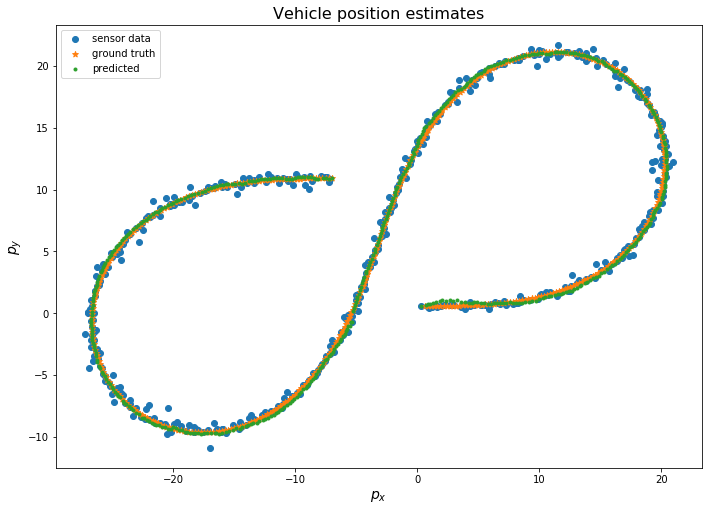

In [22]:
x_sensor, y_sensor, vx_sensor, vy_sensor = [], [], [], []
x_pred, y_pred, vx_pred, vy_pred, yaw_pred, dyaw_pred, t_pred = [], [], [], [], [], [], []
x_true, y_true, vx_true, vy_true, yaw_true, dyaw_true, t_true = [], [], [], [], [], [], []

radar_r_sensor=[]
radar_p_sensor=[]
radar_d_sensor=[]

i=0
for s, p, t in zip(sensor_data, state_estimations, ground_truths):
    if s.get_name() == 'lidar':
        x_s, y_s, _, _ = s.get()
        x_sensor.append(x_s)
        y_sensor.append(y_s)
        try:
            vx_sensor.append(vx_s)
            vy_sensor.append(vy_s)
        except:
            vx_sensor.append(0)
            vy_sensor.append(0)


    else:
        x_s, y_s, vx_s, vy_s = s.get()
        x_sensor.append(x_s)
        y_sensor.append(y_s)
        vx_sensor.append(vx_s)
        vy_sensor.append(vy_s)
        
    x_p, y_p, vx_p, vy_p, yaw_p, dyaw_p = p.get()
    time_p = p.get_timestamp()
    x_pred.append(x_p)
    y_pred.append(y_p)
    vx_pred.append(vx_p)
    vy_pred.append(vy_p)
    yaw_pred.append(yaw_p)
    dyaw_pred.append(dyaw_p)
    t_pred.append(time_p)
    

    x_t ,y_t , vx_t, vy_t, yaw_t, dyaw_t = t.get()
    time_t = t.get_timestamp()
    x_true.append(x_t)
    y_true.append(y_t)
    vx_true.append(vx_t)
    vy_true.append(vy_t)
    yaw_true.append(yaw_t)
    dyaw_true.append(dyaw_t)
    t_true.append(time_t)

plt.scatter(x_sensor,y_sensor,label="sensor data",marker="o")
plt.scatter(x_true,y_true,label="ground truth",marker="*")
plt.scatter(x_pred,y_pred,label="predicted",marker=".")

plt.xlabel('$p_x$', fontsize=14)
plt.ylabel('$p_y$', fontsize=14)

plt.legend()
plt.tight_layout()
plt.title('Vehicle position estimates', fontsize=16)
plt.show()

### Plot of position $p_x$, $p_y$

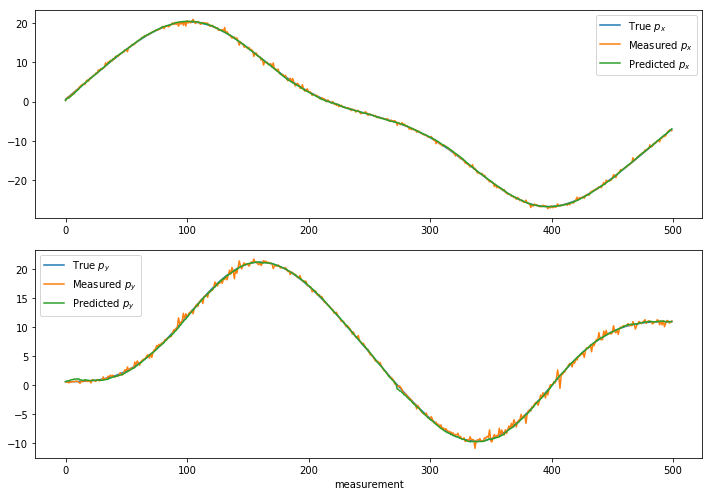

In [23]:
fig1, ax = plt.subplots(2)
ax[0].plot(x_true, label="True $p_x$")
ax[0].plot(x_sensor, label="Measured $p_x$")
ax[0].plot(x_pred, label="Predicted $p_x$")
ax[0].legend(loc='upper right')

ax[1].plot(y_true, label="True $p_y$")
ax[1].plot(y_sensor, label="Measured $p_y$")
ax[1].plot(y_pred, label="Predicted $p_y$")
ax[1].legend(loc='upper left')
ax[1].set_xlabel('measurement')

fig1.tight_layout()
plt.show()

### Plot of velocity $v_x$, $v_y$

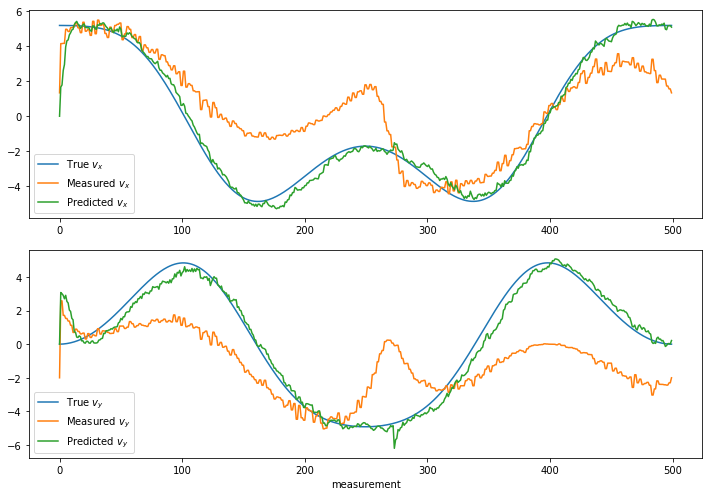

In [24]:
fig2, ax = plt.subplots(2)

ax[0].plot(vx_true, label="True $v_x$")
ax[0].plot(vx_sensor, label="Measured $v_x$")
ax[0].plot(vx_pred, label="Predicted $v_x$")
ax[0].legend(loc='lower left')

ax[1].plot(vy_true, label="True $v_y$")
ax[1].plot(vy_sensor, label="Measured $v_y$")
ax[1].plot(vy_pred, label="Predicted $v_y$")
ax[1].legend(loc='lower left')
ax[1].set_xlabel('measurement')

fig2.tight_layout()
plt.show()

### Plot of yaw and yaw rate $\psi$, $\dot{\psi}$

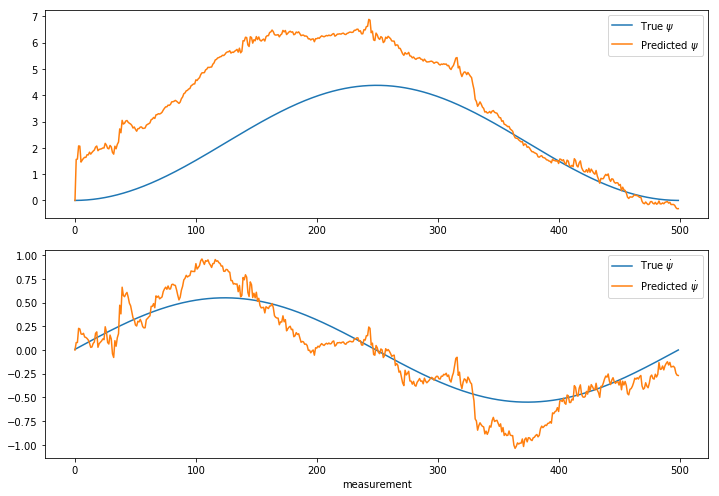

In [25]:
fig3, ax = plt.subplots(2)

ax[0].plot(yaw_true, label="True $\psi$")
ax[0].plot(yaw_pred, label="Predicted $\psi$")
ax[0].legend(loc='upper right')

ax[1].plot(dyaw_true, label="True $\dot{\psi}$")
ax[1].plot(dyaw_pred, label="Predicted $\dot{\psi}$")
ax[1].legend(loc='upper right')
ax[1].set_xlabel('measurement')

fig3.tight_layout()
plt.show()

## References:

- E. A. Wan and R. Van Der Merwe, "The unscented Kalman filter for nonlinear estimation," Proceedings of the IEEE 2000 Adaptive Systems for Signal Processing, Communications, and Control Symposium (Cat. No.00EX373), Lake Louise, AB, Canada, 2000, pp. 153-158, doi: 10.1109/ASSPCC.2000.882463.

- https://winfriedauner.de/projects/unscented/ctrv/

- Helper functions [tools.py](./utils/tools.py) and [datapoint.py](./utils/datapoint.py) from https://github.com/mithi/fusion-ekf-python